In [1]:
%load_ext autoreload
%autoreload 2

In [109]:
from utils import (
    read_synthesized_strands_from_file, sample_reads,
    get_fastq_records, get_badread_strand_id
)
from evaluation import get_recovery_rate
from Levenshtein import ratio
from clustering import Clustering
import json
import matplotlib.pyplot as plt
from strand_reconstruction import align, multiple_alignment_muscle, make_prediction
from collections import Counter
from heirarchal_clustering import calculate_centroid, get_edit_distance_matrix
import numpy as np
from tqdm import tqdm
import sys

np.set_printoptions(threshold=sys.maxsize)

In [ ]:

original_strands, original_strand_ids = read_synthesized_strands_from_file(file_path=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\cat.jpg_RU10 2.fasta")

In [ ]:
with open('raptor_data.json', 'r') as f:
    read_dict = json.load(f)

reads = read_dict['reads']
ids = read_dict['ids']

In [111]:
sampled_reads, sampled_ids = sample_reads(reads, ids, n_samples=10000)

In [112]:
clustering = Clustering(
    strand_pool=sampled_reads, reference_length=len(original_strands[0]), original_strands=original_strands,
      strand_pool_ids=sampled_ids, original_strand_ids=original_strand_ids, distance_threshold=20)

Filtering strands by length
0.0361 strands filtered out
Removing adapters


100%|██████████| 9639/9639 [00:00<00:00, 21889.77it/s]


Clustering strands
Total strands 9639


100%|██████████| 9639/9639 [00:55<00:00, 174.25it/s]


Number of clusters = 2143
Clusters are sorted
Orientation fixed in the strand pool
Generating candidates


100%|██████████| 2143/2143 [01:55<00:00, 18.57it/s]


Fixing candidate orientations
0.5048996733551097 candidates are reversed
Evaluating candidates


2143it [00:28, 74.95it/s]


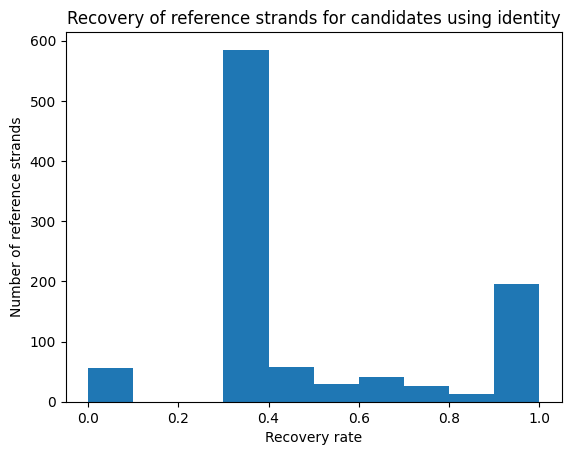

In [113]:
clustering.run_pipeline()

2143it [00:28, 74.75it/s]


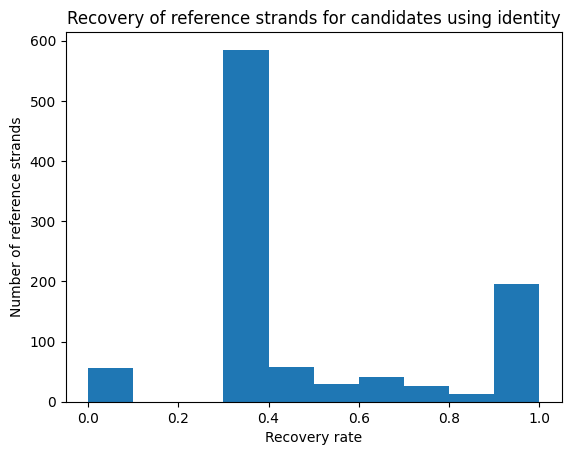

In [114]:
evaluation_dict_identity = clustering.evaluate_candidates(hist=True, metric='identity')

2143it [00:06, 314.74it/s]


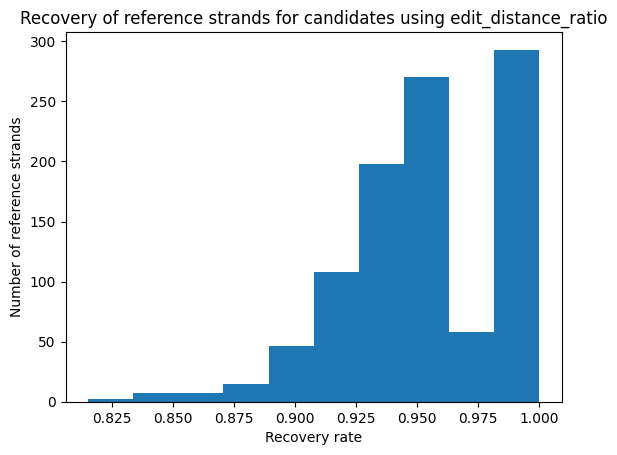

In [116]:
evaluation_dict_distance = clustering.evaluate_candidates(hist=True, metric='edit_distance_ratio')

(array([  3.,   8.,  17.,  28.,  76., 145., 320., 440., 139., 967.]),
 array([0.81518987, 0.83367089, 0.8521519 , 0.87063291, 0.88911392,
        0.90759494, 0.92607595, 0.94455696, 0.96303797, 0.98151899,
        1.        ]),
 <BarContainer object of 10 artists>)

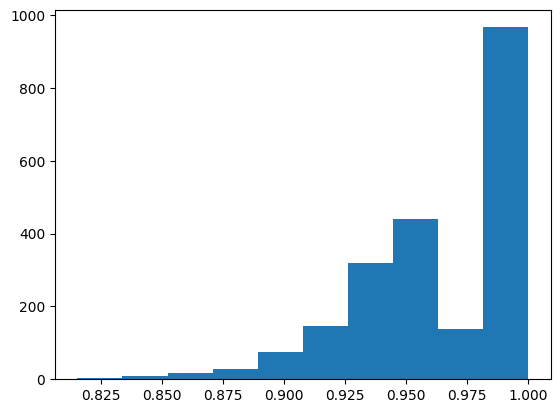

In [118]:
plt.hist(evaluation_dict_distance['recovery_rates'])

In [120]:
evaluation_dict_identity['recovery_rates'][:200]

array([1.   , 1.   , 1.   , 1.   , 1.   , 0.34 , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 0.345, 1.   , 1.   , 0.35 , 1.   , 1.   , 1.   ,
       1.   , 0.34 , 0.995, 1.   , 1.   , 0.335, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.345, 0.54 , 0.375,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 0.355, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 0.355, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 0.35 , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.36 , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.37 , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   ,

In [121]:
evaluation_dict_identity['reference_strand_indices'][:70]

array([115., 353., 233., 391., 612., 844., 529., 789.,  87., 317., 486.,
       492., 453., 532.,  57., 208., 457., 298., 357., 766., 408., 964.,
       982., 883.,  74.,  96., 104., 454., 870., 481., 875., 616., 792.,
       808.,  45., 513., 476., 516., 999., 125., 348., 668., 719., 468.,
       123., 727., 393., 241., 455., 618., 519., 922., 607., 178., 706.,
       786., 916., 929., 301., 818., 959., 629., 813.,  84., 914., 910.,
       309., 889., 880., 892.])

In [93]:
evaluation_dict_distance['recovery_rates'][10]

np.float64(0.9925558312655087)

In [94]:
evaluation_dict_distance['reference_strand_indices'][10]

np.float64(981.0)

In [95]:
alignment = align(clustering.candidates[10], original_strands[981])

In [96]:
print(alignment.counts())

AlignmentCounts(gaps=131, identities=134, mismatches=0)


In [61]:
print(ratio(clustering.candidates[10], original_strands[871]))

0.6550868486352357


In [71]:
edit_dist_matrix = get_edit_distance_matrix(clustering.clustered_seqs[10])

In [72]:
centroid = calculate_centroid(clustering.clustered_seqs[10], edit_distance_matrix=edit_dist_matrix)

In [74]:
print(ratio(centroid, original_strands[981]))

0.9950248756218906


In [75]:
for i in clustering.clustered_seqs[10]:
    print(ratio(i, original_strands[981]))

0.9773299748110831
0.935251798561151
0.9680589680589681
0.985
0.9727047146401985
0.9827160493827161
0.9875311720698254
0.9950248756218906
0.9611650485436893
0.975
0.9704433497536946
0.9680589680589681
0.9850746268656716
0.9825436408977556
0.9751243781094527
0.9850746268656716
0.9491525423728814
0.987468671679198


In [ ]:
# picking closest strand
def get_n_closest_strands(edit_distance_matrix: np.ndarray)

array([[ 0., 29., 17., 11., 14., 14., 10.,  9., 21., 13., 15., 19., 13.,
        11., 15., 11., 26.,  9.],
       [29.,  0., 20., 28., 30., 22., 25., 26., 32., 30., 23., 34., 30.,
        27., 24., 28., 43., 27.],
       [17., 20.,  0., 14., 17.,  8., 11., 12., 17., 17., 10., 20., 16.,
        14., 14., 14., 27., 13.],
       [11., 28., 14.,  0., 10., 11.,  7.,  6., 17., 11., 14., 16.,  8.,
         8., 12.,  8., 23.,  7.],
       [14., 30., 17., 10.,  0., 14.,  9.,  9., 19., 12., 17., 17., 11.,
        10., 15.,  8., 24., 10.],
       [14., 22.,  8., 11., 14.,  0.,  9.,  9., 16., 14.,  8., 19., 12.,
        11., 12., 11., 26., 10.],
       [10., 25., 11.,  7.,  9.,  9.,  0.,  5., 16.,  9., 12., 15.,  9.,
         7., 10.,  7., 22.,  6.],
       [ 9., 26., 12.,  6.,  9.,  9.,  5.,  0., 16.,  9., 12., 14.,  8.,
         6., 10.,  6., 21.,  5.],
       [21., 32., 17., 17., 19., 16., 16., 16.,  0., 21., 18., 10., 14.,
        17., 19., 16., 19., 17.],
       [13., 30., 17., 11., 12., 14.,

In [84]:
evaluation_dict_distance['reference_strand_indices']

array([287., 628., 301., ..., 179., 566., 105.])

In [ ]:

# get ratios of centroids
for i in tqdm(range(len(clustering.candidates[:1004]))):
    edit_dist_matrix = get_edit_distance_matrix(clustering.clustered_seqs[i])
    centroid = calculate_centroid(strands = clustering.clustered_seqs[i], edit_distance_matrix=edit_dist_matrix)
    reference_strand = original_strands[int(evaluation_dict_distance['reference_strand_indices'][i])]
    print(ratio(centroid, reference_strand))
    print(ratio(clustering.candidates[i], reference_strand))
    print(ratio(clustering.candidates[i], centroid))
    print()
    print(edit_dist_matrix)
    print()

    print(align())

    if i ==10:
        break

  1%|          | 10/1004 [00:00<00:02, 473.74it/s]

0.9924812030075187
1.0
0.9924812030075187

[[ 0. 11.  6.  5.  6. 10.  5.  8.  7.  8.  6.  6.  7. 18.  8. 15.  9.  7.
  11.  8. 12.]
 [11.  0. 11. 10. 11. 15. 11. 13. 12. 11. 12. 10. 12. 23. 13. 20. 14. 12.
   8. 13. 13.]
 [ 6. 11.  0.  5.  6. 10.  6.  8.  7.  8.  7.  6.  7. 18.  8. 15.  9.  7.
  11.  8. 12.]
 [ 5. 10.  5.  0.  5.  9.  3.  7.  6.  7.  6.  5.  6. 17.  6. 14.  8.  6.
   9.  7. 11.]
 [ 6. 11.  6.  5.  0. 10.  6.  8.  7.  8.  7.  6.  7. 17.  8. 15.  9.  7.
  11.  8. 12.]
 [10. 15. 10.  9. 10.  0. 10. 12. 11. 12. 10. 10. 11. 22. 10. 19. 13. 11.
  15. 12. 16.]
 [ 5. 11.  6.  3.  6. 10.  0.  8.  7.  8.  7.  6.  7. 18.  8. 15.  9.  7.
  11.  8. 12.]
 [ 8. 13.  8.  7.  8. 12.  8.  0.  9.  9.  9.  8.  9. 20. 10. 17. 11.  9.
  13. 10. 14.]
 [ 7. 12.  7.  6.  7. 11.  7.  9.  0.  9.  8.  7.  8. 19.  9. 16. 10.  8.
  12.  9. 13.]
 [ 8. 11.  8.  7.  8. 12.  8.  9.  9.  0.  9.  8.  9. 19. 10. 15. 11.  9.
  13. 10. 14.]
 [ 6. 12.  7.  6.  7. 10.  7.  9.  8.  9.  0.  7.  8. 19.  8. 16. 1